# Local chiral potentials

This notebook is dedicated to local chiral potentials. It creates the figures in the manuscript associated with this potential.

We use here the local chiral potentials [GT+](https://arxiv.org/abs/1406.0454) up to N2LO, which are commonly used in quantum Monte Carlo (QMC) calculations of finite nuclei and infinite matter. 

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")
output_dir = "./output"

import numpy as np
import matplotlib.pyplot as plt
from Potential import Potential, chiral, chiral_affine
from Channel import Channel
from ScatteringExp import ScatteringExp
from RseSolver import RseSolver
from Grid import Grid
from plots.rc_params import *
from string import ascii_lowercase as alphabet

## Affine version

We have developed an affine decomposed version of the original `C++` source code provided by the developers. It matches the original, non-affine decomposed version of the code very well. This section illustrates the workflow.

First, we obtain the parameter-independent portion of the chiral potentials:

In [2]:
potentialArgs = {"label": "chiral", "potId": 233}
channel = Channel(S=1, L=2, LL=2, J=1, channel=0)  # pick here the channel
potential = Potential(channel, **potentialArgs)
r = 1 # fm
aff_decomp = chiral_affine(r, channel, **potentialArgs)
aff_decomp

array([  -5.53041341,   15.31411662,   15.31411662, -102.3864922 ,
        307.15947659, -102.3864922 ,  307.15947659, -140.04679124,
        220.85788572, -662.57365715,    0.        ,    0.        ])

Note that several terms are equivalent or multiple of each other. This is because of the partial wave decomposition. 

Next, we read in the values of the low-energy couplings (LECs) from the provided data (i.e., `yaml`) files:

In [3]:
import yaml
with open("data/localGT+_lecs_order_2_R0_0.9_lam_1000.yaml", 'r') as stream:
    lecs = yaml.safe_load(stream)
lecs

{'potId': 233,
 'order': 2,
 'R0': 0.9,
 'lambda': 1000,
 'CS': 7.74784,
 'CNN': 0.04164,
 'CPP': 0.06329,
 'CT': 0.45247,
 'C1': -0.21715,
 'C2': 0.03457,
 'C3': -0.11535,
 'C4': 0.11818,
 'C5': -2.41603,
 'C6': 0.15463,
 'C7': -0.26709}

Next, we reconstruct a local chiral potential using the affine decomposition. This involves a dot product. We also evaluate the potential using the function provided by the developers. The two functions should result in the same results:

In [4]:
lec_vec = np.array([1.] + [lecs[elem] for elem in ("CS", "CT", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "CNN", "CPP")])
potval_via_aff_decomp = aff_decomp @ lec_vec
potval = chiral(r, channel,  **lecs)
diff = np.abs(potval_via_aff_decomp - potval)
assert diff < 1e-13, f"difference (aff. vs. nonaffine evaluation): {diff:e} MeV"

For completeness, let's plot the potential in the requested partial-wave channel:

Text(0.5, 1.0, '$^3$D$_{1}$')

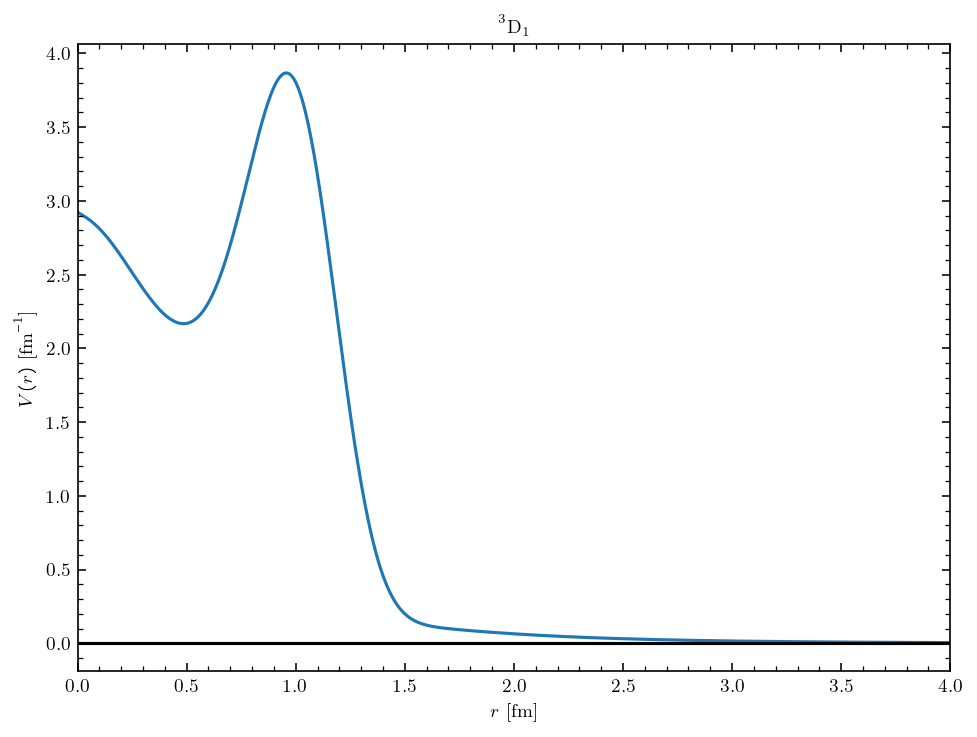

In [5]:
from constants import hbarc
rarr = np.linspace(0., 4., 1000)
yarr = np.array([chiral(r, channel, **lecs) for r in rarr])
plt.plot(rarr, yarr / hbarc)
plt.axhline(0, c="k")
plt.xlabel("$r$ [fm]")
plt.xlim(0,4)
plt.ylabel("$V(r)$ [fm$^{-1}$]")
plt.title(channel.spectNotationTeX)

The figure can be compared with Figure 14 in [Hoppe et al.](https://arxiv.org/pdf/1707.06438) (2017).

## Benchmarking the matrix Numerov method (Figure 2)

In [6]:
potentialArgs = {"label": "chiral", "potId": 213}
trainingLecList, validationLecList = Potential.getSampleLecs(potentialArgs["label"])
rmin, rmatch = 1e-12, 12
grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
            type="linear", test=False) 
solver_args = dict(asympParam="K", matching=True)

def f(E_MeV, channel, inhomogeneous=True):
    potential = Potential(channel, **potentialArgs)
    scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)
    solver = RseSolver(scattExp, grid, inhomogeneous=inhomogeneous)
    scattSols_numerov = solver.solve(lecList=validationLecList, method="Numerov", **solver_args)
    scattSols_rk45 = solver.solve(lecList=validationLecList, method="RK45", **solver_args)
    return [scattSols_numerov[0], scattSols_rk45[0]]

In [7]:
from Potential import minnesota_affine
channel = Channel(S=0, L=0, LL=0, J=0, channel=0)
potential = Potential(channel, **potentialArgs)
rarr = np.array([1e-40, 0.1, 0.2])
res = np.array([chiral_affine(r, channel, **potentialArgs) / hbarc for r in rarr])

In [8]:
lvalues = [0, 1, 2, 3, 4]
energies_MeV = [10.0, 20.0, 25.0, 50.0, 100.0]
for l in lvalues:
    channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
    for E_MeV in energies_MeV:
        res = f(E_MeV, channel, inhomogeneous=True)
        res = [res[0].Lmatrix.phaseShift, res[1].Lmatrix.phaseShift]
        # print(f"l = {l} | E = {E_MeV} | {np.real(res)[0]}") 
        # print(f"{np.real(res)[0]}") 
        print(f"{np.abs(res[0]-res[1])}") 
    print()

7.693025594335268e-08
6.720858891640091e-08
6.648856754054577e-08
8.223995706657661e-08
1.7839892585413963e-07

9.556648805641998e-10
3.904526479914239e-09
6.281855036149864e-09
3.143242466308038e-08
1.5629385785587147e-07

1.899558288442904e-11
3.1674929346081626e-10
5.668419067461627e-10
4.315601209725628e-09
2.5240453283004172e-08

1.287525641657794e-11
3.124779324181759e-10
9.60222568124891e-10
8.462142098153436e-09
5.701017791182039e-08

8.676325977119426e-11
2.787395314562957e-11
3.572739326607177e-11
1.1687680823158075e-09
1.241085878511683e-08



working on 1S0
working on 1P1
working on 1D2
working on 1F3
working on 1G4


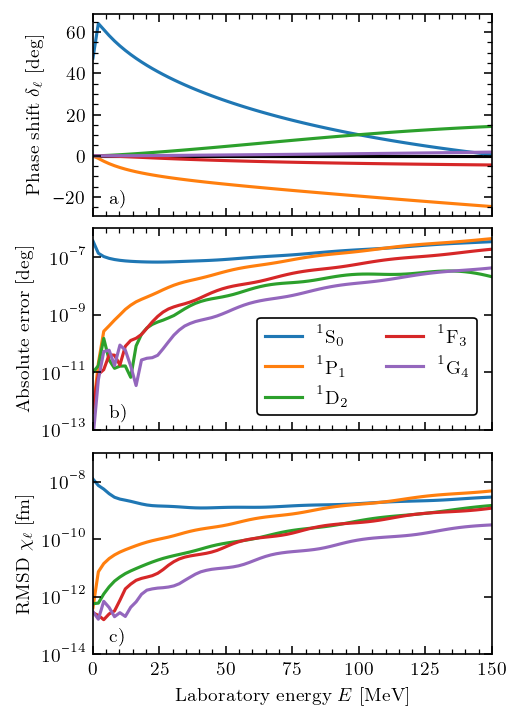

In [9]:
from constants import cm
import pandas as pd
inhomogeneous = True
lvalues = [0, 1, 2, 3, 4] # , 8] # , 12]
channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 
energies_MeV = np.linspace(1e-1, 150, 75)
fig, axs = plt.subplots(3,1, sharex=True, figsize=(8.6*cm,12*cm), constrained_layout=True)

for channel in channels:
    print("working on", channel.spectNotation)
    ret_raw = []
    for E_MeV in energies_MeV:
        ret_raw.append(f(E_MeV=E_MeV, channel=channel, inhomogeneous=inhomogeneous))

    ret = np.array([[elem[0].Lmatrix.phaseShift, elem[1].Lmatrix.phaseShift] for elem in ret_raw])
    df = pd.DataFrame(data={"Energies (MeV)": energies_MeV,
                            "Numerov (deg)": ret[:,0], 
                            "RK45 (deg)": ret[:,1]})
    df.to_csv(f"{output_dir}/benchmkark_numerov_chiral_phaseshifts_{channel.spectNotation}.csv",
              index=False, float_format="%.5f")
    axs[0].plot(energies_MeV, np.real(ret[:,0]))
    axs[1].plot(energies_MeV, np.abs(ret[:,0]-ret[:,1]), label=channel.spectNotationTeX)
    rms_error = [np.linalg.norm((elem[0].u - elem[1].u))/ np.sqrt(len(elem[0].u)) for elem in ret_raw ]
    axs[2].plot(energies_MeV, rms_error, label=channel.spectNotationTeX)

axs[0].axhline(0, color = "k", zorder=0)
axs[0].set_ylabel("Phase shift $\delta_\ell$ [deg]")

axs[1].set_yscale('log')
axs[1].set_ylim(bottom=1e-13, top=1e-6)
axs[1].set_xlim(left=0, right=150)
axs[1].set_ylabel("Absolute error [deg]") #  $\Delta \delta_\ell$ [deg]")
axs[1].legend(ncol=2) # title="$\ell = $"

axs[2].set_yscale('log')
axs[2].set_ylim(bottom=1e-14, top=1e-7)
axs[2].set_xlim(left=0, right=150)
axs[2].set_ylabel("RMSD $\chi_\ell$ [fm]")
axs[2].set_xlabel("Laboratory energy $E$ [MeV]")

for iax, ax in enumerate(axs):
    ax.text(0.04, 0.06, f"{alphabet[iax]})", transform=ax.transAxes)

fig.savefig(f"{output_dir}/numerov_benchmark.pdf")